In [1]:
import torch
from torch import nn
import math

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
import torch.optim as optim
from tqdm import tqdm

c:\Users\KandaMaya\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        # convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten for FC
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [3]:
def train(model, trainloader, optimizer, loss_func):
    loss_func = nn.CrossEntropyLoss()
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    # For every batch
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = loss_func(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / len(trainloader)
    epoch_acc = (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [4]:
def test(model, testloader, loss_func):
    loss_func = nn.CrossEntropyLoss()
    model.eval()

    class_correct = [0.] * 10
    class_total = [0.] * 10

    test_running_loss = 0.0
    test_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            outputs = model(image)
            loss = loss_func(outputs, labels)
            test_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds == labels).sum().item()

    epoch_loss = test_running_loss / len(testloader)
    epoch_acc = (test_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [5]:
matplotlib.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
download_data = True
# device = torch.device('cpu')
epochs = 5
batch_size = 32

transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor()])

# dataset and data loader
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=download_data, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=download_data, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
                                             

In [6]:
def epoch_train(train_dataloader_, test_dataloader_):
    loss_func = nn.CrossEntropyLoss()
    model = VGG11().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay=0.0005)
    train_loss, test_loss = [], []
    train_acc, test_acc = [], []
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_dataloader_, 
                                                optimizer, loss_func)
        test_epoch_loss, test_epoch_acc = test(model, test_dataloader_,  
                                                    loss_func)
        train_loss.append(train_epoch_loss)
        test_loss.append(test_epoch_loss)
        train_acc.append(train_epoch_acc)
        test_acc.append(test_epoch_acc)
        print('\n')
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Test loss: {test_epoch_loss:.3f}, test acc: {test_epoch_acc:.3f}")
        print('-'*50)
    return model, train_loss, test_loss, train_acc, test_acc

In [7]:
model, train_loss, test_loss, train_acc, test_acc = epoch_train(train_dataloader, test_dataloader)

[INFO]: Epoch 1 of 5


100%|██████████| 313/313 [00:01<00:00, 213.90it/s]




Training loss: 0.141, training acc: 0.959
Test loss: 0.039, test acc: 0.988
--------------------------------------------------
[INFO]: Epoch 2 of 5


100%|██████████| 313/313 [00:01<00:00, 228.92it/s]




Training loss: 0.047, training acc: 0.987
Test loss: 0.039, test acc: 0.989
--------------------------------------------------
[INFO]: Epoch 3 of 5


100%|██████████| 313/313 [00:01<00:00, 223.68it/s]




Training loss: 0.036, training acc: 0.990
Test loss: 0.031, test acc: 0.991
--------------------------------------------------
[INFO]: Epoch 4 of 5


100%|██████████| 313/313 [00:01<00:00, 223.36it/s]




Training loss: 0.028, training acc: 0.992
Test loss: 0.044, test acc: 0.987
--------------------------------------------------
[INFO]: Epoch 5 of 5


100%|██████████| 313/313 [00:01<00:00, 223.69it/s]



Training loss: 0.027, training acc: 0.992
Test loss: 0.021, test acc: 0.994
--------------------------------------------------


[]

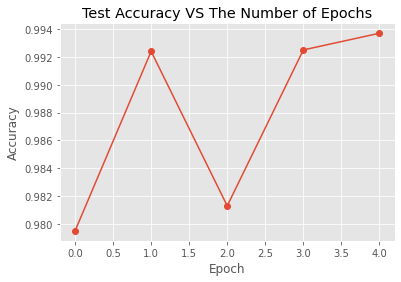

In [8]:
# Draw Graphs:
plt.figure(facecolor='white')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(epochs), test_acc, marker='o')
plt.title(f"Test Accuracy VS The Number of Epochs")
plt.savefig(f"Test Accuracy VS The Number of Epochs")
plt.plot()

[]

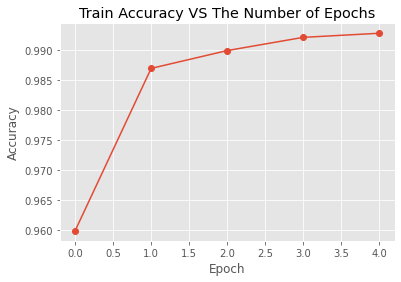

In [9]:
plt.figure(facecolor='white')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(epochs), train_acc, marker='o')
plt.title("Train Accuracy VS The Number of Epochs")
plt.savefig("Train Accuracy VS The Number of Epochs")
plt.plot()

[]

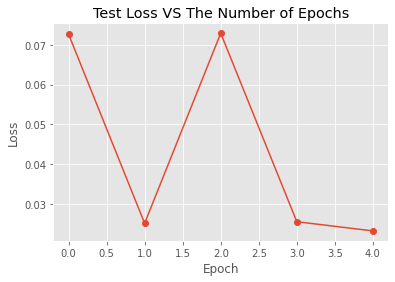

In [10]:
plt.figure(facecolor='white')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(epochs), test_loss, marker='o')
plt.title(f"Test Loss VS The Number of Epochs")
plt.savefig(f"Test Loss VS The Number of Epochs")
plt.plot()

[]

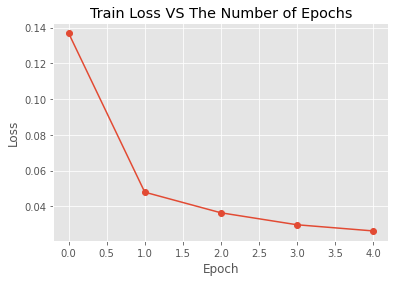

In [11]:
plt.figure(facecolor='white')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(epochs), train_loss, marker='o')
plt.title(f"Train Loss VS The Number of Epochs")
plt.savefig(f"Train Loss VS The Number of Epochs")
plt.plot()

In [12]:
def test_flip(_model):
    loss_func = nn.CrossEntropyLoss()
    lr_flip_transform = transforms.Compose(
        [transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor()])

    td_flip_transform = transforms.Compose(
        [transforms.Resize((32, 32)),
        transforms.RandomVerticalFlip(p=1),
        transforms.ToTensor()])
        
    lr_flip_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=download_data, transform=lr_flip_transform)
    lr_flip_dataloader = torch.utils.data.DataLoader(lr_flip_dataset, batch_size=batch_size, shuffle=False)

    td_flip_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=download_data, transform=td_flip_transform)
    td_flip_dataloader = torch.utils.data.DataLoader(td_flip_dataset, batch_size=batch_size, shuffle=False)

    lr_flip_loss, lr_flip_acc = test(_model, lr_flip_dataloader, loss_func)
    td_flip_loss, td_flip_acc = test(_model, td_flip_dataloader, loss_func)
    print(f"Horizontal flip loss: {lr_flip_loss}, Accuracy: {100. * lr_flip_acc}%")
    print(f"Vertical flip loss: {td_flip_loss}, Accuracy: {100. * td_flip_acc}%")

In [13]:
def test_noise(_model):
    loss_func = nn.CrossEntropyLoss()
    for variance in [0.01, 0.1, 1]:
        stddev = math.sqrt(variance)
        gaussian_noise_transform = transforms.Compose(
            [transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x : x + stddev*torch.randn_like(x))
            ])
            
        gaussian_noise_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=download_data, transform=gaussian_noise_transform)
        gaussian_noise_dataloader = torch.utils.data.DataLoader(gaussian_noise_dataset, batch_size=batch_size, shuffle=False)
        gaussian_noise_loss, gaussian_noise_acc = test(_model, gaussian_noise_dataloader, loss_func)
        print(f"Gaussian noise with variance {variance} loss: {gaussian_noise_loss}, Accuracy: {100. * gaussian_noise_acc}%")

In [14]:
test_flip(model)
test_noise(model)

100%|██████████| 313/313 [00:02<00:00, 145.28it/s]


Horizontal flip loss: 3.9679313482948766, Accuracy: 38.84%
Vertical flip loss: 3.777954571544172, Accuracy: 41.31%


100%|██████████| 313/313 [00:02<00:00, 152.50it/s]


Gaussian noise with variance 0.01 loss: 0.030365108773648813, Accuracy: 99.2%


100%|██████████| 313/313 [00:01<00:00, 161.30it/s]


Gaussian noise with variance 0.1 loss: 0.3227496799855187, Accuracy: 90.03999999999999%


100%|██████████| 313/313 [00:02<00:00, 155.92it/s]

Gaussian noise with variance 1 loss: 2.8280732026115394, Accuracy: 20.19%


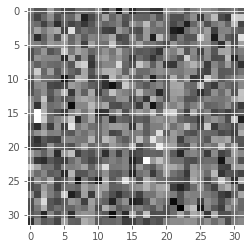

In [15]:
gaussian_noise_transform = transforms.Compose(
        [transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x : x + math.sqrt(1)*torch.randn_like(x))
        ])
        
gaussian_noise_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=download_data, transform=gaussian_noise_transform)
gaussian_noise_dataloader = torch.utils.data.DataLoader(gaussian_noise_dataset, batch_size=batch_size, shuffle=False)
images, labels = next(iter(gaussian_noise_dataloader))
plt.imshow(images[4].reshape(32,32), cmap="gray")

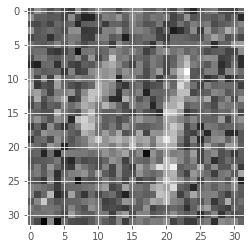

In [16]:
gaussian_noise_transform = transforms.Compose(
        [transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x : x + math.sqrt(0.1)*torch.randn_like(x))
        ])
        
gaussian_noise_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=download_data, transform=gaussian_noise_transform)
gaussian_noise_dataloader = torch.utils.data.DataLoader(gaussian_noise_dataset, batch_size=batch_size, shuffle=False)
images, labels = next(iter(gaussian_noise_dataloader))
plt.imshow(images[4].reshape(32,32), cmap="gray")

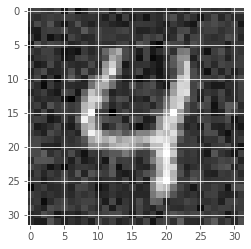

In [17]:
gaussian_min_noise_transform = transforms.Compose(
        [transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x : x + math.sqrt(0.01)*torch.randn_like(x))
        ])
        
gaussian_min_noise_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=download_data, transform=gaussian_min_noise_transform)
gaussian_min_noise_dataloader = torch.utils.data.DataLoader(gaussian_min_noise_dataset, batch_size=batch_size, shuffle=False)
images, labels = next(iter(gaussian_min_noise_dataloader))
plt.imshow(images[4].reshape(32,32), cmap="gray")

In [18]:
aug_lr_transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.RandomHorizontalFlip(p=0.4),
     transforms.ToTensor(),
     ])

aug_td_transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.RandomVerticalFlip(p=0.4),
     transforms.ToTensor(),
     ])

gau_transform = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Lambda(lambda x : x + math.sqrt(0.1)*torch.randn_like(x)),
    ]
)

aug_lr_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=download_data, transform=aug_lr_transform)
aug_td_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=download_data, transform=aug_td_transform)
gau_dataset = torchvision.datasets.MNIST(root = './data', train=True, download=download_data, transform=gau_transform)


aug_loader_cat = torch.utils.data.ConcatDataset([aug_lr_dataset, aug_td_dataset, gau_dataset])
aug_loader = torch.utils.data.DataLoader(aug_loader_cat, batch_size=batch_size, shuffle=True)

In [19]:
aug_model, aug_train_loss, aug_test_loss, aug_train_acc, aug_test_acc = epoch_train(aug_loader, test_dataloader)

[INFO]: Epoch 1 of 5


100%|██████████| 313/313 [00:01<00:00, 218.22it/s]




Training loss: 0.174, training acc: 0.948
Test loss: 0.055, test acc: 0.983
--------------------------------------------------
[INFO]: Epoch 2 of 5


100%|██████████| 313/313 [00:01<00:00, 222.25it/s]




Training loss: 0.073, training acc: 0.979
Test loss: 0.042, test acc: 0.988
--------------------------------------------------
[INFO]: Epoch 3 of 5


100%|██████████| 313/313 [00:01<00:00, 220.53it/s]




Training loss: 0.061, training acc: 0.982
Test loss: 0.052, test acc: 0.983
--------------------------------------------------
[INFO]: Epoch 4 of 5


100%|██████████| 313/313 [00:01<00:00, 202.25it/s]




Training loss: 0.053, training acc: 0.985
Test loss: 0.035, test acc: 0.989
--------------------------------------------------
[INFO]: Epoch 5 of 5


100%|██████████| 313/313 [00:01<00:00, 202.81it/s]



Training loss: 0.051, training acc: 0.985
Test loss: 0.040, test acc: 0.988
--------------------------------------------------


In [20]:
test_flip(aug_model)
test_noise(aug_model)

100%|██████████| 313/313 [00:02<00:00, 152.76it/s]


Horizontal flip loss: 0.09681220558384945, Accuracy: 97.16%
Vertical flip loss: 0.10574187763100758, Accuracy: 96.91%


100%|██████████| 313/313 [00:01<00:00, 167.39it/s]


Gaussian noise with variance 0.01 loss: 0.03433592035969795, Accuracy: 98.99%


100%|██████████| 313/313 [00:01<00:00, 168.15it/s]


Gaussian noise with variance 0.1 loss: 0.04499677672183302, Accuracy: 98.58%


100%|██████████| 313/313 [00:01<00:00, 167.43it/s]

Gaussian noise with variance 1 loss: 1.3255716820304004, Accuracy: 60.36%
